### Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

In [2]:
dataset = pd.read_csv('data/HAM10000_metadata.csv')

In [3]:
copy_metadata = dataset.copy()
copy_metadata = copy_metadata.sort_values('image_id')
metadata_slim = copy_metadata[['image_id', 'dx']]
metadata_slim.reset_index(drop=True, inplace=True)
metadata_slim

,image_id,dx
0,ISIC_0024306,nv
1,ISIC_0024307,nv
2,ISIC_0024308,nv
3,ISIC_0024309,nv
4,ISIC_0024310,mel
...,...,...
10010,ISIC_0034316,mel
10011,ISIC_0034317,mel
10012,ISIC_0034318,bkl
10013,ISIC_0034319,nv


In [4]:
label_dict = { 
    'akiec': 0,'bcc': 1,'bkl': 2,'df': 3,'nv': 4,
    'vasc': 5,
    'mel': 6}

In [5]:
metadata_labels = metadata_slim.replace(label_dict)
#pd.get_dummies(metadata_labels

In [6]:
metadata_slim[:1000].dx.value_counts()

nv       685
bkl      111
mel       91
bcc       52
akiec     36
vasc      14
df        11
Name: dx, dtype: int64

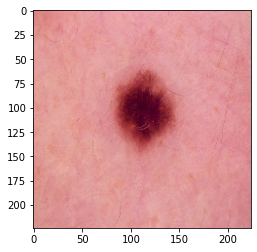

In [7]:
image_one_path = 'data/HAM10000_images_part_1/ISIC_0024407.jpg'
target_size=(224, 224)
original_image = image.load_img(image_one_path, target_size=target_size)
plt.imshow(original_image)

## Confusion Matrix Function

In [9]:
image_array = image.img_to_array(original_image)
print(image_array.min(), image_array.max())

0.0 248.0


In [12]:
#image_array = image.img_to_array(original_image)
img_reshaped = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))
print(img_reshaped.shape)

(1, 224, 224, 3)


In [13]:
prepared_image = preprocess_input(img_reshaped)
print(prepared_image.min(), prepared_image.max())

-1.0 0.94509804


In [10]:
prepared_image.shape

(1, 224, 224, 3)

In [14]:
def get_preprocessed_images(images_directory: str, image_size: tuple,limit:int) -> list:
    images = []
    i = 0
    for img in os.listdir(images_directory):
        img = image.load_img(images_directory+img, target_size=image_size)
        img = image.img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        images.append(img)
        i += 1
        if i > limit:
            return np.vstack(images)

In [15]:
image_size =(224,224)
skin_image = get_preprocessed_images("data/HAM10000_images_part_1/", image_size, 200)#put it back at 2000

In [20]:
skin_image.max()

1.0

In [17]:
X = skin_image.copy()
y = metadata_labels.dx[:201]
target = tf.keras.utils.to_categorical(y, num_classes=7, dtype="int")

## TRAIN & SPLIT DATA

In [18]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    target,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

### BASE MODEL WITHOUT TRANSFER LEARNING

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D
from tensorflow.keras.layers import Flatten, MaxPool2D
from tensorflow.keras.layers import Dropout
# from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience = 3)

base_model = Sequential()
base_model.add(Conv2D(7, kernel_size=4, activation='relu', input_shape = (224,224,3)))
base_model.add(MaxPool2D(2))
base_model.add(BatchNormalization())
base_model.add(Flatten())
base_model.add(Dense(64, activation='relu'))
base_model.add(Dropout(0.25))
base_model.add(Dense(35, activation='relu'))
base_model.add(Dense(7, activation='softmax'))



# Summarize.
#base_model.summary()

In [21]:
base_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
base_history = base_model.fit(X_train,y_train, epochs=20, batch_size=20,validation_data=(X_val,y_val), callbacks = [early_stopping_monitor])
base_model.save('model/base_model_no_tl.h5')

Epoch 1/20
64/64 [==============================] - 15s 31ms/step - loss: 10.1441 - accuracy: 0.5789 - val_loss: 3.5273 - val_accuracy: 0.6875
Epoch 2/20
64/64 [==============================] - 1s 20ms/step - loss: 3.4270 - accuracy: 0.5828 - val_loss: 1.5430 - val_accuracy: 0.7094
Epoch 3/20
64/64 [==============================] - 1s 20ms/step - loss: 2.1776 - accuracy: 0.6562 - val_loss: 1.6455 - val_accuracy: 0.7063
Epoch 4/20
64/64 [==============================] - 1s 19ms/step - loss: 1.7785 - accuracy: 0.6836 - val_loss: 1.1793 - val_accuracy: 0.7031
Epoch 5/20
64/64 [==============================] - 1s 19ms/step - loss: 1.3241 - accuracy: 0.6820 - val_loss: 1.0997 - val_accuracy: 0.7094
Epoch 6/20
64/64 [==============================] - 1s 19ms/step - loss: 1.3362 - accuracy: 0.6805 - val_loss: 1.0687 - val_accuracy: 0.6969
Epoch 7/20
64/64 [==============================] - 1s 19ms/step - loss: 1.2385 - accuracy: 0.6953 - val_loss: 1.1063 - val_accuracy: 0.6969
Epoch 8/20


In [ ]:
import tensorflow

def plot_history(history : tensorflow.keras.callbacks.History):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 2])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(base_history)

In [ ]:
base_model.summary()